In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from TPE import train_best_dgm_model, train_best_mim_model
import optuna
from IPython.display import HTML

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
spatial_dims = 2

In [2]:
best_heat_dgm = optuna.load_study(study_name=f"DGM Heat {spatial_dims}D", storage="sqlite:///dgm_heat.db")
dgm, dgm_best_loss, dgm_stats = train_best_dgm_model(best_heat_dgm, spatial_dims, 300)
dgm_stats

Training: 100%|██████████| 300/300 [00:13<00:00, 22.87it/s, loss=4.45e-01, val_loss=5.07e-02, rolling_val_loss=4.76e-02, best_val_loss=3.57e-02, mean=3.45e-02, std=1.92e-01, lr=2.16e-03]


Training completed with best loss: 0.03574645519256592


{'mean': 0.10084451735019684,
 'std': 0.18485137820243835,
 'max': 0.427996426820755,
 'min': -0.2533780336380005,
 'abs_mean': 0.17779812216758728}

In [ ]:
best_heat_mim = optuna.load_study(study_name=f"MIM Heat {spatial_dims}D", storage="sqlite:///mim_heat.db")
mim, mim_best_loss, mim_stats = train_best_mim_model(best_heat_mim, spatial_dims, 300)
mim_stats

In [3]:
def gen_heat_ani(model, grid_size=1000, n_time_steps=100):
    # Define the grid size and spatial coordinates
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
    # Convert spatial grid to torch tensor
    grid_tensor = torch.tensor(grid_points).float().to(DEVICE)
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))
    cax = ax.imshow(np.zeros((grid_size, grid_size)), extent=(0, 1, 0, 1), origin="lower", cmap="hot", vmin=-0.5, vmax=1)
    fig.colorbar(cax, label="Temperature")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Stochastic Heat Equation Evolution")
    # Animation function
    def animate(t):
        time_tensor = torch.tensor(t).float().repeat(grid_size ** 2, 1).to(DEVICE)
        with torch.no_grad():
            output = model(grid_tensor, time_tensor)
            if isinstance(output, tuple):
                output = output[0]
        solution = output.cpu().numpy().reshape(grid_size, grid_size)
        cax.set_array(solution)
        ax.set_title(f"Stochastic Heat Equation Solution at time t={t:.2f}")
    # Create animation, range can be adjusted to cover desired time steps
    time_steps = np.linspace(0, 1, n_time_steps)  # For example, from t=0 to t=1
    ani = FuncAnimation(fig, animate, frames=time_steps, interval=50)
    return ani

MovieWriter imagemagick unavailable; using Pillow instead.


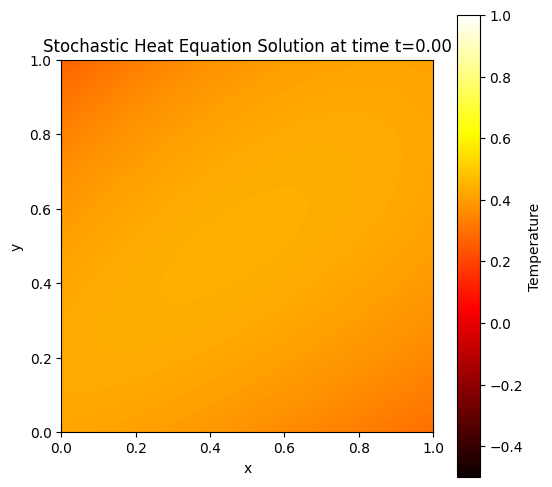

In [4]:
dgm_heat_ani = gen_heat_ani(dgm)
dgm_heat_ani.save("dgm_heat_ani.gif", writer="imagemagick", fps=10)
HTML(dgm_heat_ani.to_jshtml())

In [ ]:
mim_heat_ani = gen_heat_ani(mim)
mim_heat_ani.save("mim_heat_ani.gif", writer="imagemagick", fps=10)
HTML(mim_heat_ani.to_jshtml())